# Introduction to Data Science and Systems 2023-2024<small><small>v20232024a</small></small>
## Lab 2: Optimisation
#### - ***you should submit this notebook on Moodle along with one pdf file (see the end of the notebook and Moodle for instructions)***
---
#### University of Glasgow, JHW (amended by BSJ and NP)


$$\renewcommand{\vec}[1]{ {\bf #1}} 
\renewcommand{\real}{\mathbb{R}}
\renewcommand{\argmin}{\operatorname{arg\,min}}
$$

## Purpose of this lab

This lab should help you:    
* understand how optimisation can be used to solve approximation problems.
* understand how learning can be seen as an optimisation problem.
* use automatic differentiation to accelerate optimisation.

You will implement a very simple form of **deep learning** in this lab, using first-order optimisation to learn an approximating function. This is just a function and you don't need to know anything about deep learning!

We highly recommend starting watching this video [**How machines learn**](https://www.youtube.com/watch?v=IHZwWFHWa-w), which conveys excellent intuitions and visualisations about optimisaiton in the context of neural networks (in a similar style as the lecture material presents the concept).


## Guide

Lab 2 is structured as follows (with two main task sections):

>-    **Task A: Tour of optimizaiton (random search, hill-climbing and gradient descent from scratch)**
>-    **Task B: Optimising the weights in a basic neural network for face pose estimation**
>-    **Appendix: Marking Summary (and additional metadata)**

We recommend you read through the lab *carefully* and work through the tasks.

#### Material and resources 
- It is recommended to keep the lecture notes (from lecture 3 in particular) open while doing this lab exercise. 
    * ... and you should, of course, be prepared to access some of the recommended material.
- If you are stuck, the following resources are very helpful:
 * [NumPy cheatsheet](https://web.itu.edu.tr/iguzel/files/Python_Cheat_Sheets.pdf)
 * [NumPy API reference](https://numpy.org/doc/stable/)
 * [NumPy user guide](https://numpy.org/doc/stable/user/index.html)

#### Marking and Feedback
This assessed lab is marked using two different techniques;

- Autograded with feedback; you'll get immediate feedback.
- Autograded without (immediate) feedback (there will typically be a small demo/test so you can be confident that the format of your answer is correct).

*Note*: auto-graded results are always provisional and subject to change in case there are significant issues (this will usually be in favour of the student).

#### Help \& Assistance
- This lab is graded and the lab assistants/lecturer can provide guidance, but we can (and will) not give you the final answer or confirm your result.

#### Plagiarism
- All submissions will be automatically compared against each other to make sure your submission represents an independent piece of work! We have provided a few checks to make sure that is indeed the case.


---

## Before you start
You need to install `autograd`. The cell below will autoinstall this for you if the machine you are using does not already have it installed.

***Note***: It is often easier to install packages externally to the notebook, especially on macOS. You can find more information [here](https://github.com/HIPS/autograd) in case the below install instructions fails. Make sure you install the packages in the correct Python installation / virtual environment.



In [1]:
try:
    import autograd.numpy as np
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten
    print("autograd succesfully imported. Everything OK so far. ")
except:
    import os
    import sys     
    print(sys.version)
    print(os.path)
    # couldn't import, install the package
    print("autograd not found.\nInstalling...")
    %pip install autograd
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    

autograd succesfully imported. Everything OK so far. 


If you are using Google Colab, as before you need to install the dependencies and data files. 

In [2]:
#%pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master

# the following will allow you to downlad the data files you need (that are otherwise in the zip file)
# you can comment this line after the first run. 
#!pip install wget
#try: 
#    !wget https://github.com/pugeault/IDSS2023-24/raw/main/lab2-files.zip
#    !unzip lab2-files.zip

In [3]:
## Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
#import numpy as np  # NumPy we use autograd's wrapped version !
import os
import sys
import binascii
from unittest.mock import patch
from uuid import getnode as get_mac

# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick
np.set_printoptions(suppress=True)

# reset the visble marks counter
tick.reset_marks()

# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), 'utf-8')) ##TODO change to ascii finally
    if verbose:
        print(h_crc)
    return h_crc

# this command generaties a unique key for your system/computer/account
uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
print("Everything imported OK")
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

d:\ProgramData\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Everything imported OK


**Mini-task**: provide your personal details in two variables:

* `student_id` : a string containing your student id (e.g. "1234567x"), must be 8 chars long.
* `student_typewritten_signature`: a string with your name (e.g. "Adam Smith") which serves as a declaration that this is your own work (read the declaration of originality when you submit on Moodle).

In [4]:
student_id = "2931267N" # your 8 char student id
student_typewritten_signature = "Siyu Na" # your full name, avoid spceical chars if possible

# YOUR CODE HERE
# raise NotImplementedError()

In [5]:
## We will print your info to a pdf file at the end of the notebook - 
# including the Declaration of Originality - which must be uploaded alongside 
# the actual notebook. You should also see two green "v [0 marks] 
# indicating that your info meet the basic std.

with tick.marks(0): # you don't get any credit for remembering your student id. This is just a test!
    assert(len(student_id)==8)

with tick.marks(0):  # you don't get any credit for remembering your own name! This is just a test!
    assert(len(student_typewritten_signature)>0)

# Tasks

---

## Task A: Objective functions and gradient descent

### Background

If you are unsure about objective functions, read [the supplement](idss_lab_topic_03_optimisation_supplement_objective_functions.ipynb) or the first part of the lecture notes from Lecture 4.

* An optimisation *problem* has **parameters**, (possibly) **constraints** and an **objective function**.

* An optimisation *algorithm* has **hyperparameters** which determine how the search for the best parameter setting is conducted (for example, how big of a step to take when trying to move down the gradient of a function).

* We will be working with **differentiable** objective functions, where we can compute the gradient of the function at any point, and use this information to quickly move towards the minimum.

### Simple optimisation

Suppose we have a 2D parameter space ($\theta \in \real^2$), and an objective function we want to minimise:

$$L(\theta) = \sum\limits_{i=0}^{I-1}(\theta_i-i)^2$$

where $I$ is the length of the vector $\theta$ (i.e. $I=2$ for a 2D problem).

We can write this in code:



In [6]:
## Define our objective function. In this case we formulate it as a 
# loss function (to be minimised) that can take theta of any length (not only 2D).
def l(theta):
    i = np.arange(len(theta))   # 0, 1,...
    return np.sum((theta-i)**2) # sum of squared difference  

In [7]:
# some random point
theta_0 =  np.array([0.1, 0.2])

# compute loss (objective function value) at this point (in 2D)
print("The loss function at %s evaluates to %s" % (theta_0,l(theta_0)))

The loss function at [0.1 0.2] evaluates to 0.6500000000000001


We can visualize the loss function in 3D... 

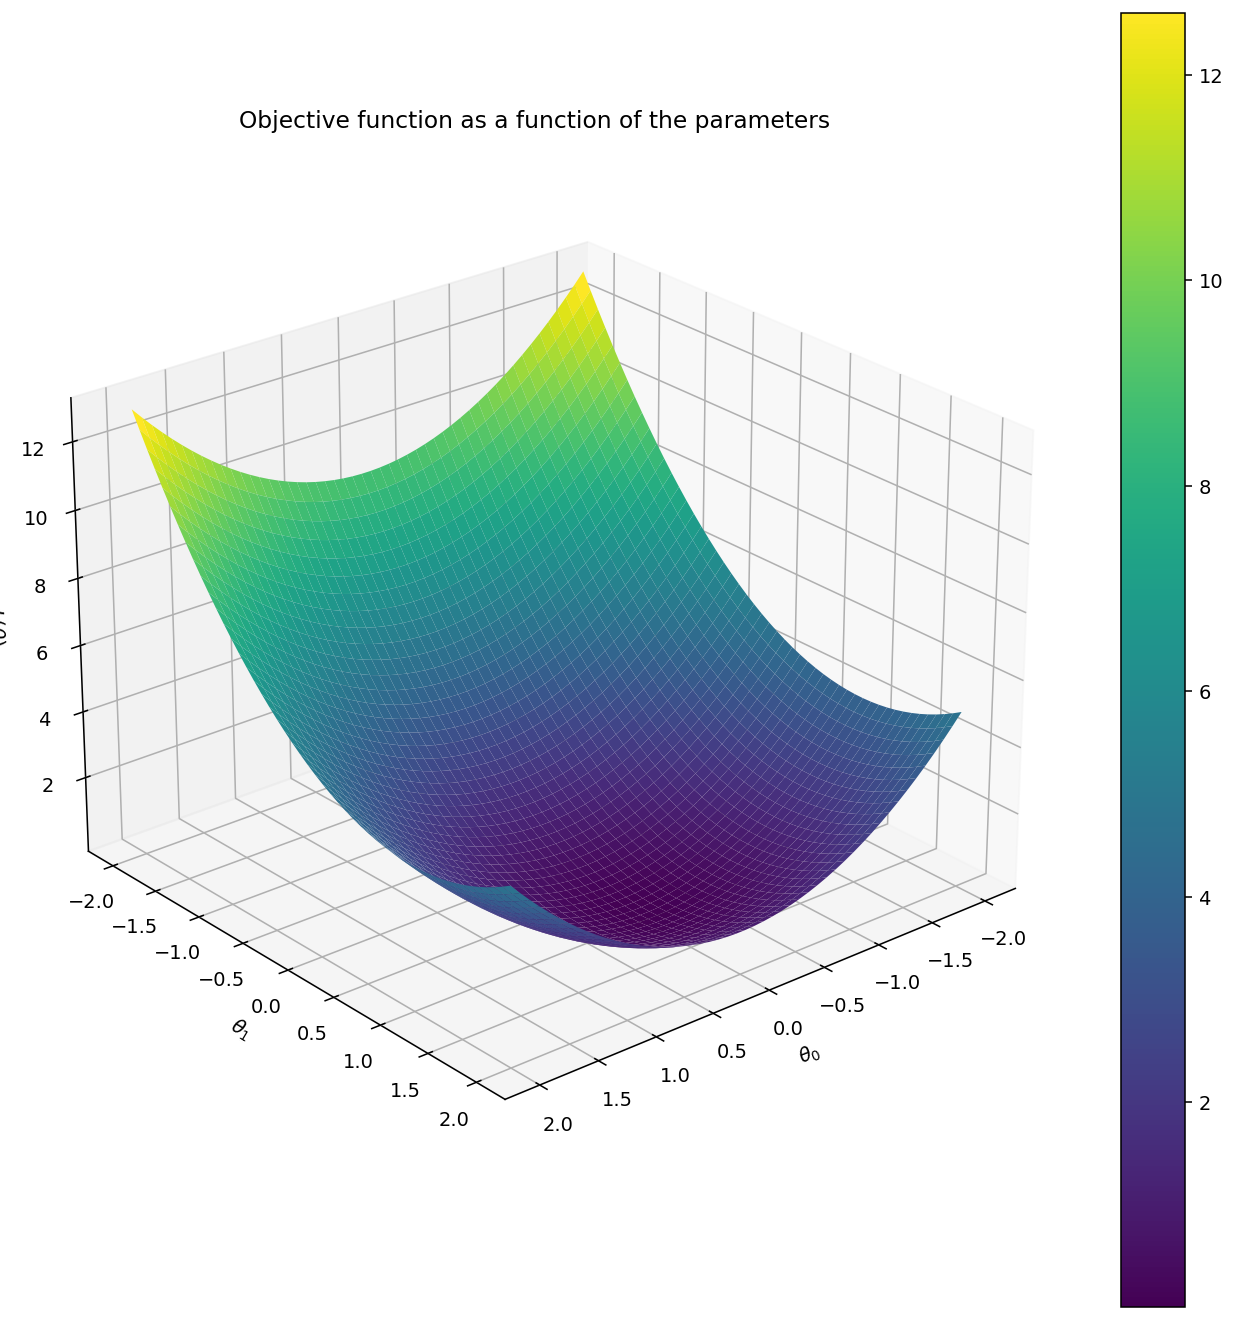

In [8]:
## Show the objective function as a function of parameters
space = np.linspace(-2,2,50)
xm, ym = np.meshgrid(space, space)
pts = np.stack([xm.ravel(), ym.ravel()]).T

# compute the objective function at a grid
# of different parameter values
zm = np.zeros((pts.shape[0]))
for i in range(pts.shape[0]):
    zm[i] = l(pts[i])
%matplotlib inline

## plot in 3D
from mpl_toolkits.mplot3d import Axes3D
fig_a1a = plt.figure(figsize=(12,12))
ax = fig_a1a.add_subplot(1,1,1, projection='3d')
zm = np.array(zm).reshape(xm.shape)
sf = ax.plot_surface(xm,ym,zm,cmap='viridis')
ax.set_zlabel("$L(\\theta)$")

ax.set_xlabel("$\\theta_0$")
ax.set_ylabel("$\\theta_1$")
ax.set_title("Objective function as a function of the parameters")              
ax.view_init(25, 50) # try changing this to ispect teh funciton from different angles
fig_a1a.colorbar(sf)

---
**Task A.1 Optional warm-up - manual optimisation and visualisation [ungraded, no marks]**

We encourage you to visualise the loss function as a contour plot and determine if the function is convex or not (hint see the lecture notes for relevant code).

- The figure (`fig_a1b`) should contain a contour plot of $L(\theta)$ or $log(L(\theta))$ including contour lines and labels. It should contain a red marker at the minimum (i.e. you should solve the optimisation problem manually, which is almost trivial in this case and only require you to look at the contour plot). The figure should follow best practices in visualization, e.g. following [Ten Simple Rules for Better Figures](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833).
- `A1_EXPLANATION`: should contain a brief explanation if the function is convex (from both the images and formulation of the objective function) and argue how you can see that. 

***This task is ungraded but we encourage you to discuss your visualisation and explanation with your group members and lab assistant.***


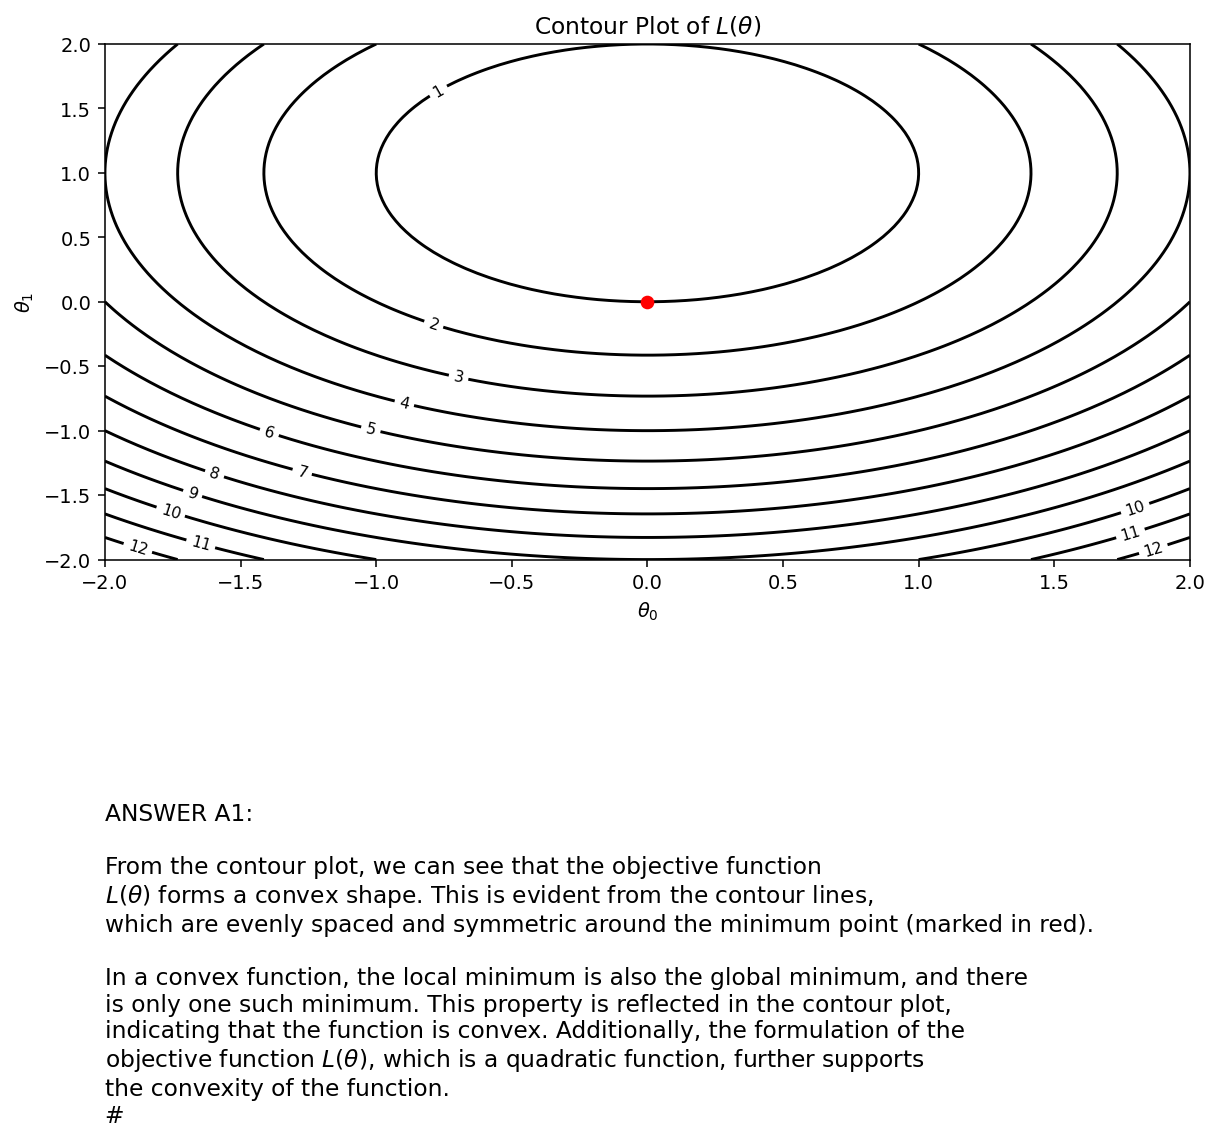

In [9]:
# Plot the contour plot
# Do not modify the figure
fig_a1b = plt.figure(figsize=(10,10)) # DO NOT MODIFY
ax_explanation = fig_a1b.add_subplot(4,1,(3,4))  # DO NOT MODIFY
ax = fig_a1b.add_subplot(4,1,(1,2))  # DO NOT MODIFY
####################################
theta_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(theta_range, theta_range)
Z = np.zeros_like(X)
for i in range(len(theta_range)):
    for j in range(len(theta_range)):
        Z[i, j] = l([X[i, j], Y[i, j]])
contours = ax.contour(X, Y, Z, levels=15, colors='k')
ax.clabel(contours, inline=True, fontsize=8)
ax.set_xlabel("$\\theta_0$")
ax.set_ylabel("$\\theta_1$")
ax.set_title("Contour Plot of $L(\\theta)$")
minimum_coordinates = [0, 0]  # Replace with actual minimum coordinates
ax.plot(minimum_coordinates[0], minimum_coordinates[1], 'ro', label='Minimum')

A1_EXPLANATION = """
From the contour plot, we can see that the objective function 
$L(\\theta)$ forms a convex shape. This is evident from the contour lines, 
which are evenly spaced and symmetric around the minimum point (marked in red).

In a convex function, the local minimum is also the global minimum, and there 
is only one such minimum. This property is reflected in the contour plot, 
indicating that the function is convex. Additionally, the formulation of the 
objective function $L(\\theta)$, which is a quadratic function, further supports 
the convexity of the function.
# """
# A1_EXPLANATION = """
# [YOUR ANSWER HERE]
# """

# raise NotImplementedError()

###################################################
### This adds your text (do not change this!)
ax_explanation.axis('off')
try:
    ax_explanation.text(0,0,("ANSWER A1:\n%s" % A1_EXPLANATION), fontsize=12)
except:
    ax_explanation.text(0,0,"ERROR A1_EXPLANATION NOT PROVIDED") 
    raise NotImplemented() # this is to give you an option to define A1_EXPLANATION above! 
###################################################

Using a computer, how can we find the value where this objective function has a minimum -- the setting of $\theta$ that minmises $L(\theta)$? 

### Random search: guessing solutions
One solution would be to use purely random search:

In [10]:
def random_search(l, max_iters, guess_fn,n_dim):
    best_guess, best_loss = None, None    
    for i in range(max_iters):
        # random guess
        guess = guess_fn(n_dim)
        loss = l(guess) # work out how bad it is
        # check if we beat the record
        if best_loss is None or l(guess)<best_loss:
            best_loss = l(guess)
            best_guess = guess
    return best_guess

# guess a vector between -10 and 10, with n_dim elements 
def guess(n_dim):
    return np.random.uniform(-30, 30, n_dim) 

# try 10 repetitions
np.random.seed(2018)
for i in range(10):
    result =  random_search(l, 10000, guess, len(theta_0))
    print("Best random guess {guess}, loss {loss:.4f}".format(guess=result, loss=l(result)))
    

Best random guess [-0.32157305  1.30044392], loss 0.1937
Best random guess [0.04639978 1.37873791], loss 0.1456
Best random guess [0.46256818 0.89255229], loss 0.2255
Best random guess [-0.09604507  0.88077837], loss 0.0234
Best random guess [0.26852601 0.64722717], loss 0.1966
Best random guess [-0.03212773  1.62380175], loss 0.3902
Best random guess [-0.3064073   0.97287146], loss 0.0946
Best random guess [-0.1600626   1.11567807], loss 0.0390
Best random guess [-0.18440358  0.76348086], loss 0.0899
Best random guess [-0.05960545  0.70083547], loss 0.0931


*Note* we might get close to the optimium but certainly not within the tolerance we would normally expect (e.g. loss< 1e-6)!

### Hill climbing (or rather hill descent in our case)
Random guessing does okay in this case as we are in 2D - but it will not work very well in high dimensions (you should try!), and only come somewhat close to `[0,1]`. But the space of the objective function is continuous, and our objective function might also be continuous. This means we could take advantage of the continuity; a small change in our parameters might lead to a small change in the objective function.

**Task A.2** Write code to do hill-climbing search (keeing in mind that we want to minimise our function), instead of pure random search. Adjust the parameterisation of the search until the tests pass (this should be relatively easy). Note that the test will test against a **random** target; you can't hardcode the solution to just return a certain array!

In [11]:
# In this cell define three function
#   hill_climbing(...): see description above
#   guess(n_dim): takes number of dimensions as input and returns a random guess
#   neighbour(x): takes a guess x as input and returns a modification of a current estimate for theta

def hill_climbing(l, max_iters, guess_fn, neighbour_fn,n_dim):    
    current_guess = guess_fn(n_dim)
    current_loss = l(current_guess)
    for i in range(max_iters):
        candidate_guess = neighbour_fn(current_guess)
        candidate_loss = l(candidate_guess)
        if candidate_loss < current_loss:
            current_guess = candidate_guess
            current_loss = candidate_loss
    return current_guess
    # raise NotImplementedError()
def guess(n_dim):
    return np.random.uniform(-1, 1, n_dim)
    # YOUR CODE HERE
    # raise NotImplementedError()
def neighbour(x):
    return x + np.random.normal(0, 0.1, len(x))
    # YOUR CODE HERE
    # raise NotImplementedError()

#### Testing hill-climbing
The code below will test your solution. It should be apparent that hill climbing does a much better job, getting to a good solution within 5000 iterations.

You must have defined functions:
    
* `hill_climbing`
* `guess`: returns a random guess (e.g. in [-40,40] for each dimension)
* `neighbour`: returns a modification of a current estimate for theta

How you implement and use these is up to you.

The hill climbing optimiser should expect to optimise a 2 element parameter vector.

In [12]:
# try running hill_climbing 10 times with random targets
with tick.marks(8):
    np.random.seed(2023)
    passed = False
    n_dim = 2
    for i in range(10):
        target = np.random.uniform(0,4,n_dim)
        print("Target %s" % target)
        # use a random target :)
        def custom_l(theta):
            return np.sum((theta-target)**2)          
        # 5000 iterations
        result = hill_climbing(custom_l, 5000, guess, neighbour,n_dim)
        difference = custom_l(result)               
        print("Loss on run {i} is {loss:.2e}".format(i=i, loss=difference))        
        if difference<0.1:
            passed = True            
    assert(passed)    

Target [1.28795322 3.56168981]
Loss on run 0 is 3.59e-06
Target [1.26576843 1.73592557]
Loss on run 1 is 2.80e-07
Target [3.39867526 3.34367146]
Loss on run 2 is 3.29e-06
Target [1.61852909 1.89777753]
Loss on run 3 is 2.50e-06
Target [0.75519478 0.45235468]
Loss on run 4 is 2.27e-06
Target [3.5074038  1.23415776]
Loss on run 5 is 8.54e-06
Target [2.54710449 1.14566273]
Loss on run 6 is 2.05e-06
Target [2.04870138 1.58459593]
Loss on run 7 is 3.18e-06
Target [0.07465757 2.33564013]
Loss on run 8 is 9.61e-07
Target [3.14118832 2.5016319 ]
Loss on run 9 is 3.56e-06


### Beyond continuity: differentiability and gradient descent
Having a continuous objective function made it easy to optimise this solution (look at the solutions found by hillclimbing compared to random search), compared to having to use pure random search. We can do much better, however.

If we can differentiate `l` (the loss function) then we can use **gradient descent** to solve the problem, using the algorithm:

$$\vec{\theta^{(i+1)}} = \vec{\theta^{(i)}} - \delta \nabla L(\vec{\theta^{(i)}}) \,\,\,\,\,\,\,\, [\textit{Equation 1}]$$

which only relies on:
- the parameter vector: $\vec{\theta}$
- the gradient vector (or Jacobian): $\nabla L(\vec{\theta})$ 
- the step size: $\delta > 0$ (keep in mind the Lipschitz constant when choosing a step size; see the lecture notes for details).
- $i$ is the iteration number


**Task A.3** 

By hand (using pen and paper) compute the gradient of $L(\vec{\theta})$, (i.e., a vector containing $\frac{\partial l(\vec{\theta})}{{\partial \vec{\theta}_n}})$ elements for all paramaters $\theta_n$), and specify the gradient vector based on your derivations. Implement it in a function called `grad_l_manual` that takes `theta` as input and returns the gradient vector $\nabla L(\vec{\theta})$ .

*Hint*: You may need to recall techniques from high-school and consult a resource on rules for computing the derivative (e.g. [Wikipedia](https://en.wikipedia.org/wiki/Derivative) or [Math is Fun](https://www.mathsisfun.com/calculus/)). The key lesson is how these gradients are combined to form the Jacobian.

**Note:** You can leave this task for later as the subsequent tasks do not depend on it being correct.

In [13]:
def grad_l_manual(theta):
    # YOUR CODE HERE
    # supposed that L = (o1-0)^2+(o2-1)^2
    dL_dtheta_0 = 2 * theta[0] #true
    dL_dtheta_1 = 2 * (theta[1] - 1)
    nabla_l = np.array([dL_dtheta_0, dL_dtheta_1])
    return nabla_l
    # raise NotImplementedError()
    # return nabla_l # a (2,) vector with elements [dL(theta) / dtheta_0, dL(theta) / dtheta_1]


In [14]:
# Autograded test with immediate feedback [10 marks]
#
# Note: this test is a bit complicated and you do not have to understand it in detail
#
#

n_dim = 2
with tick.marks(10): 
    # Check that the manual_grad computes the correct values
    np.random.seed(2023)        
    true_hash = np.array([13.010153770733421, 10.671065773392218, 17.62368288798055, 22.941032270315958, 19.817154702514454, 
                          8.277943969325982, 7.6426611520121615, 7.511895266923034, 4.945909123232264, 14.513047942162961])  
    mg_test=grad(l)(np.random.uniform(20,1,n_dim))        
    assert(check_hash(mg_test, ((2,), 111.74936948106736)))  

    
    for i_test in range(10):       
        target = np.random.uniform(0,4,n_dim) # do not change it changes the hash
        # Manual

        with patch('__main__.grad') as mock_grad: # put here to have some other hidden code in the loop ;-)        
            with patch('__main__.elementwise_grad') as mock_elementwise_grad:                        
                    m_grad = grad_l_manual(np.array(target))
                    assert(mock_elementwise_grad.called==False) # "You have used the autograd function - that's not ok!")
                    assert(mock_grad.called==False) # "You have used the autograd function - that's not ok!")                                                                                                         
                    assert(check_hash(m_grad, ((2,),true_hash[i_test]))) # "You have used the autograd function !")                                                                                                                               
 

Deriving and implementing the gradient by hand can be tedious. `autograd` makes the whole process trivially easy, and can automatically compute the derivatives of our code without custom gradient vector implementations:

In [15]:
## create a handle to a function which can compute the gradient of l with respect to theta
# NOTE: This is evaluated at a specific point and does not return the analytic function you derived
# above -- but that's fine for gradient descent.
grad_l = grad(l)

In [16]:
# this will be a vector, with as many dimensions as theta
theta_0 = np.array([0.1, 0.2])

print("theta_0: %s" % theta_0)
print("gradient vector of l(theta) evaluated at theta_0: %s" % grad_l(theta_0))

theta_0: [0.1 0.2]
gradient vector of l(theta) evaluated at theta_0: [ 0.2 -1.6]


You may want to make sure that this also works for high dimension data (e.g. 10D).

The result is a **vector** which points in the direction where the objective function should be decreasing. We can try moving a small amount in this direction, computing the loss as we go.

**Task A.4**
Implement the gradient decent algorithm (as defined in Equation 1) which 
- iterates the update rule for 20 iterations (no other stopping rules)
- uses a stepsize of 0.2. 
- uses the `grad_l` for gradient computation (not `grad_l_manual`).
- starts in $\theta^{(0)} = [-0.5, 2.75]$
- print (in each iteration) the current solution and the loss of that solution
- store the final solution in `theta_20`

*Hint*: This should be a simple for-loop.

In [17]:
theta_0 = np.array([-0.5, 2.75])
delta = 0.2 # how big of steps to take
n_steps = 20
print("Initial loss: %s" % (l(theta_0)))
# YOUR CODE HERE
for i in range(n_steps):
    gradient = grad_l(theta_0) 
    theta_0 = theta_0 - delta * gradient 
    loss = l(theta_0)  
    print(f"Iteration {i + 1}: Theta = {theta_0}, Loss = {loss}")
theta_20 = theta_0
# print your final solution (hopefully something close to the optimum)
print("Solution=%s" % theta_20)

Initial loss: 3.3125
Iteration 1: Theta = [-0.3   2.05], Loss = 1.1924999999999997
Iteration 2: Theta = [-0.18  1.63], Loss = 0.42929999999999985
Iteration 3: Theta = [-0.108  1.378], Loss = 0.15454799999999994
Iteration 4: Theta = [-0.0648  1.2268], Loss = 0.05563727999999995
Iteration 5: Theta = [-0.03888  1.13608], Loss = 0.020029420799999993
Iteration 6: Theta = [-0.023328  1.081648], Loss = 0.007210591487999991
Iteration 7: Theta = [-0.0139968  1.0489888], Loss = 0.0025958129356800056
Iteration 8: Theta = [-0.00839808  1.02939328], Loss = 0.0009344926568448046
Iteration 9: Theta = [-0.00503885  1.01763597], Loss = 0.00033641735646412806
Iteration 10: Theta = [-0.00302331  1.01058158], Loss = 0.00012111024832708704
Iteration 11: Theta = [-0.00181399  1.00634895], Loss = 4.359968939775246e-05
Iteration 12: Theta = [-0.00108839  1.00380937], Loss = 1.5695888183191224e-05
Iteration 13: Theta = [-0.00065303  1.00228562], Loss = 5.650519745948434e-06
Iteration 14: Theta = [-0.00039182  

In [18]:
## Sanity check that the size of theta_20 is correct
with tick.marks(0):
    assert(check_hash(0*theta_20,( (2,) , 0)))

In [19]:
# Hidden, autograded test [12 marks] - you should be able to manually validate that the method is correct before submitting.

You hopefully noticed that gradient decent reduces the objective function value, and gets very close to the true solution. While hill-climbing took thousands of iterations, and random search never got close to a good solution, this approach finds a very precise solution in only 15 iterations.

# Task B: The face direction  problem
Given an image of a head, like the rendering of the statue below, can we predict how it is oriented in space, *directly from the pixels*? For example, the image below:

<img src="new_data/face_0000.png" width=30%>

is the same face, but a different orientation (or *pose*) to this one:

<img src="new_data/face_0001.png" width=30%>

We can characterise the pose in terms of the:

* *elevation* (head tilting with chin up/down) and
* *azimuth* (head rotating left to right)

The images above have similar elevation (the noses are roughly level in both pictures), but the azimuths are very different.

***How can we use optimisation to solve this problem?*** We need to have a *parameterisable function* that somehow maps from images to poses, and then adjust the parameters until the function maps face images onto poses. That is, we want to find some function $f$ that takes an image as input, and outputs a face poses as output. $f$ must be configurable with a vector of parameters $\theta$.

* $\vec{x}$ will be the face image, represented as a simple vector, by unravelling the image
* $y$ will be the predicted face pose, as a scalar

#### Approximation
We will be trying to approximate a function. This means we have an objective function of the form:

$$L(\theta) = \|f(\vec{x};\theta)-y\|_2$$

where we measure the difference between a predicted output $f(\vec{x};\theta)$ and a real, expected output $y$, and try and minimise that difference by choosing a good setting for $\theta$.

We will build a simple "deep learning" system. We will completely ignore many of the important problems in machine learning, like overfitting, regularisation, efficient network architectures and fair evaluation,  and concentrate on using first-order optimisation to find a function that approximates a known transformation.

### Loading the data
There are 698 images of a face in different poses in the file `new_data/face_strip.png`. The faces are 64x64 grayscale images, and
have been stacked into one very long strip.
    
You can load an image with `ia.load_image_gray()`, as below:

(64, 64)


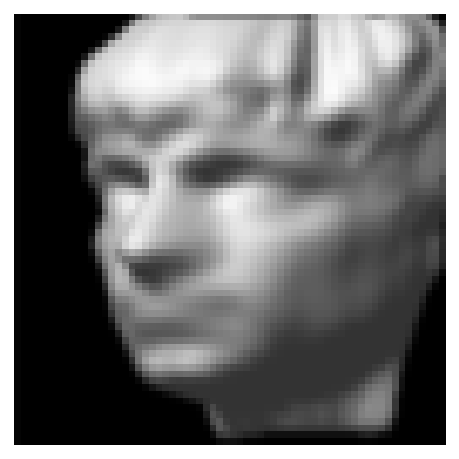

In [20]:
import skimage 
# load a single example image
# *must* divide by 65535.0 to normalise the result
def load_image_gray(fname): 
    img = skimage.io.imread(fname, plugin="pil")
    # img = skimage.color.rgb2gray(img)
    return img.astype(np.float64)

face_img = load_image_gray('new_data/face_0000.png') / 65535.0
print(face_img.shape)
ia.show_image_mpl(face_img)

###  Load the data

**Task B.1**

* Load the face data from `face_strip.png` into a single tensor `faces`.
* Reshape/rearrange it to a 698x64x64 tensor, and then slice it to take *every second* row and column of each image, giving a 698x32x32 tensor `faces`.
* Normalize it to 0.0-1.0, as above.
* Use `np.loadtxt` to load the file `new_data/face_pose_degrees.txt` as an 2x698 and transpose it into a 698x2 array `face_poses`. This contains the known orientations of the faces, *in the same order as the faces on the strip*.

In [21]:
face_strip = load_image_gray('new_data/face_strip.png')
faces = face_strip.T.reshape((698, 64, 64)) # 注意，不能直接reshape，因为他会优先按照行组成新矩阵
faces= np.rot90(faces, k=-1, axes=(1, 2)) # 这样得到的图片是不正确的，首先要逆时针90度回正
faces = faces[:, :, ::-1] #然后进行水平镜像反转
faces = (faces[:, ::2, ::2]) 
faces = faces / 65535.0
face_poses = np.loadtxt('new_data/face_pose_degrees.txt').T

If you did this correctly, you'll see a low-resolution face animation when you run the code below. The animation will jump around apparently random poses

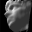

In [22]:
ia.show_gif(faces[0:10,:,:], width="150px")

In [23]:

with tick.marks(6):
    print(array_hash(faces))
    assert(check_hash(faces, ((698, 32, 32), 87092746113.97925)))


((698, 32, 32), 87092746113.97925)


In [24]:
with tick.marks(2):
    print(array_hash(face_poses))
    assert(check_hash(face_poses, ((698, 2), -1401906.2345336243)))

((698, 2), -1401906.2345336243)


## Image vectors

We have to be able to write this problem in the form:

$$L(\theta) = \|f(\vec{x};\theta)-\vec{y}\|_2$$

Every input vector $\vec{x}$ must have a corresponding matched expected output $\vec{y}$, and we need a function $f$ that depends on $\vec{x}$ and $\theta$.

### Inputs
What is $\vec{x}$? How can we define the input to this function? We need to have one vector per example; that is a matrix with one row per face image. We can do this by reshaping the `faces` tensor to unravel the 32x32 pixel image into a single 1024 dimensional vector.

Each image is then represented a single point in a 1024 dimensional space; the space of all 32x32 grayscale images.

**Task B.2**
Reshape the face tensor to a 698*1024 matrix; each row being a face image as a single "unravelled" vector. Store this in `face_inputs`.

In [25]:
face_inputs = faces.reshape(698, -1)
# raise NotImplementedError()

In [26]:
with tick.marks(4):
    print(array_hash(face_inputs))
    assert(check_hash(face_inputs,((698, 1024), 87092746113.97925)))

((698, 1024), 87092746113.97925)


### The expected outputs
$\vec{y}$ will be the *known* face orientation for each image. This is the data in `face_poses`. 

The neural network we will define will map all predictions to the range [-1,1], so $\vec{y}$ must be scaled to be in this range. The face orientations are currently stored in *degrees*.

**Task B.3**

Rescale `face_poses` by dividing it by 180.0 and storing the result in `expected_face_orientations`. This will reduce the maximum and minimum values to well inside the range [-1, 1].



In [27]:
# YOUR CODE HERE
expected_face_orientations = face_poses / 180.0
# raise NotImplementedError()

In [28]:
print("Min pose value:{min}, max pose value:{max}".format(min=np.min(expected_face_orientations), max=np.max(expected_face_orientations)))

with tick.marks(6):
    print(array_hash(expected_face_orientations))
    assert(check_hash(expected_face_orientations, ((698, 2), -7788.3679696312465)))

Min pose value:-0.41576094828348653, max pose value:0.416494067253775
((698, 2), -7788.3679696312465)


If you have done this correctly, you will see the faces laid out below, where the position the face is plotted corresponds to the orientation of the face:

In [29]:
print(face_inputs.shape)
print(expected_face_orientations.shape)

(698, 1024)
(698, 2)


Text(0.5, 1.0, 'True face orientations')

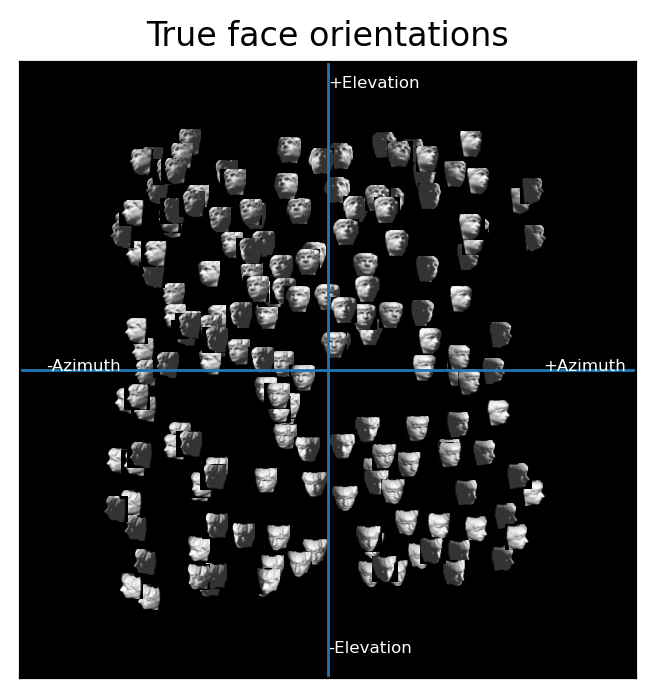

In [30]:
def show_faces(images, positions):
    # show the faces, and their orientations
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 0.025
    for i in range(0,len(positions),4):
        pos = positions[i]
        
        # show the image at the output position
        ax.imshow(images[i].reshape(faces.shape[1],faces.shape[2]), 
                  extent=[pos[0]-sz, pos[0]+sz, -pos[1]*8-sz, -pos[1]*8+sz],
                  vmin=0, vmax=1, cmap='gray')
        
    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.text(0,0.55, '+Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0,-0.55, '-Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0.42,0.0, '+Azimuth', color='w', fontdict={"fontsize":6})
    ax.text(-0.55,0.0, '-Azimuth', color='w', fontdict={"fontsize":6})
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Face orientations")
    
# apply to the *known* inputs and outputs
show_faces(face_inputs, expected_face_orientations)
plt.gca().set_title("True face orientations")

## A deep network
How will this parameterisable function that maps from images to orientations be defined? We will use a very specific and simple deep "neural network" predictor. This is an incredibly simple algorithm. It takes a vector, then repeatedly:

* adds a small constant
* takes the `tanh()` of the resulting vector; this simply squashes all the elements of the vector so they lie in the range [-1,1]
* multiplies the vector by a (different) matrix

We have to define the *shape* of each of the matrices which will be used to transform the vector, but we *optimise* to find the elements that go into those matrices. This is the "learning" part.

Each of these steps is traditionally called a "layer" of the prediction function.

In [31]:
# a very basic neural network
# the only slightly subtle thing is the unflattening, which is explained below
def predict(x, theta, unflatten):        
    for w in unflatten(theta):          
        x = w.T @ np.tanh(x + 0.1)
    return x

### Flattening and unflattening
**READ THIS CAREFULLY**

To be able to optimise this prediction function in the standard form, we have to package *all* of the things that could vary into a single "flat" parameter vector $\theta$. `predict()` can unpack a list of matrices from a single vector if it is given the right `unflatten` parameter.

We can use the `flatten` convenience function to make this easy.

    theta, unflatten = flatten(list_of_matrices)

takes a list of matrices `list_of_matrices` and returns them packed into a single 1D NumPy vector `theta` along with `unflatten`, a function which will reverse that process and unpack all the matrices when applied to `theta`.

`flatten` is like a "super-ravel" which can be reversed by the `unflatten` function which it returns. See the examples below:


In [32]:
# create a list of matrices
list_of_matrices = [np.zeros((3,3)), np.ones((2,4)), np.full((1,4), 2.0)]
print(list_of_matrices)

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


In [33]:
# convert to a flat vector
# along with a *function* which will later unflatten theta back into a list of matrices
theta, unflatten = flatten(list_of_matrices)

In [34]:
# the flattened version; a single vector
print(theta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]


In [35]:
# restore the flattened version to original shapes
print(unflatten(theta))

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


### Objective function

**Task B.4**

Write an objective function that will compare the predicted output to the expected output, for one set of input and output vectors, given `theta`, `unflatten`, `x` and `y`. Use the $L_2$ norm. The function should be of the form

    def face_loss(theta, unflatten, x, y):
        ...
        return l # a scalar
        
The loss function will need to call `predict` to calculate `y_prime`, the predicted output to compare with `y`. Assume `x` and `y` are vectors. 

In [36]:
def face_loss(theta, unflatten, x, y):
    for w in unflatten(theta):
        x = w.T @ np.tanh(x + 0.1)  
        # x = w.T @ (1 / (1 + np.exp(-x))) 
    loss = np.linalg.norm(x - y)
    return loss

# raise NotImplementedError()

In [37]:
test_network = [np.array([[1,0.5,-0.5], [0.0, 2.0, -1.0]]).T, 
                np.array([[2.0, 1.0], [1.0, -1.0]]).T]
test_theta, test_unflatten = flatten(test_network)
      
with tick.marks(5):
    assert(abs(face_loss(test_theta, test_unflatten, np.array([1,2,3]), np.array([-1, 1]))-3.37)<0.2)


### Network architecture
The choice of the matrix shapes we use to do the prediction affects how well we will be able to model the transformation.

In our example, we know we have 1024 dimensional inputs (32x32 face images unraveled into flat vectors) and 2 dimensional outputs (the pose vectors). So the we must start with 1024 dimensional vectors and end up with 2 dimensional vectors. 

However, we can introduce any number of intermediate matrices into the prediction function. This gives more parameters that could be tweaked, and more flexibility in how the mapping is learned; it makes the prediction function more *flexible*. If we have more intermediate matrices, we can "warp space" more vigorously.

A very simple model might have a single 1024,2 matrix; this would be a simple linear transformation of the inputs.

A more complex model might have a mapping with four matrices in sequence:

    W[0]     W[1]      W[2]   W[3]
    1024,32 -> 32,16 -> 16,8 -> 8,2

This "architecture" maps the 1024 dimensional input vector to some 32 dimensional space, then to some 16 dimensional space, then to some 8 dimensional space, then to the 2 dimensional output. Every matrix has to have an output dimension which matches the input dimension of the following matrix. The matrices W[0], W[1], W[2], W[3]  specify how the vector at each layer gets mapped to the next layer.

These sizes of these matrices are pretty much arbitrarily chosen here. They could have been 1024->50->20->2 or 1024->10->10->10->10->10->15->2 or many other variations. These all represent different kind of functions that can be learned, but this the specific choice turns out not to be critical. More matrices with more elements means a more flexible function which can learn more complicated things; but will be harder to optimise efficiently.

We *don't know* what values should go into these matrices; they specify some unknown transformation of the vectors in each step. We have to optimise to find the elements of these matrices. We will *discover* a warping of space from the space of images onto the space of poses. For this lab, assume that the matrix shapes to be used are:

    1024,32  32,16  16,8  8,2

This will work well, without being too hard to optimise. You can alter this if you want, but the above version is known to work.

### Network initialisation

We need to set up some *initial conditions* for the optimisation process. We can define the shape of each matrix, but we don't know what the values of the elements in the matrices should be. So we just make a random guess.

* We will create a function that generates initial conditions for the prediction function. 
* This function takes a list of matrix *shapes*, and create a corresponding list of randomly filled matrices.  
* Each matrix generated will have the specified shape.  
* The function takes a parameter `sigma` that specifies the spread of the random values chosen. We use `np.random.normal(0, sigma, shape)` to generate the random numbers.

It returns the **flattened** version of the matrix list, along with the corresponding `unflatten` function.

For example `initial_conditions([[2,3], [3,6]], 0.1)` returns the flattened version of a `(2,3)` and `(3,6)` shape random matrices.

NB! Make sure you understand this function and what it returns!


In [38]:
def initial_conditions(shape_list, sigma):
    random_matrices = []
    for shape in shape_list:
        random_matrix = np.random.normal(0, sigma, shape)
        random_matrices.append(random_matrix)
    flattened_vector = np.concatenate([matrix.flatten() for matrix in random_matrices])
    def unflatten(theta):
        matrices = []
        index = 0
        for shape in shape_list:
            size = np.prod(shape)
            matrix_vector = theta[index : index + size]
            matrix = matrix_vector.reshape(shape)
            matrices.append(matrix)
            index += size
        return matrices
    return flattened_vector, unflatten

In [39]:
## Check that initial_conditions is correct
test_theta, test_unflatten = initial_conditions([[8,4], [4,8], [2,4]], 0.1)
matrices = test_unflatten(test_theta)
with tick.marks(1):
    assert(matrices[0].shape==(8,4))
    assert(matrices[1].shape==(4,8))
    assert(matrices[2].shape==(2,4))

## Random predictions
We can use predict to see the effect of applying this function to the face images. Since all of the matrices are random, the result will be a random mess, where the positions plotted have no relation to the true orientations of the faces.

Hint: You may need to run several times to get "faces" in the plot.

Text(0.5, 1.0, 'Random face orientations')

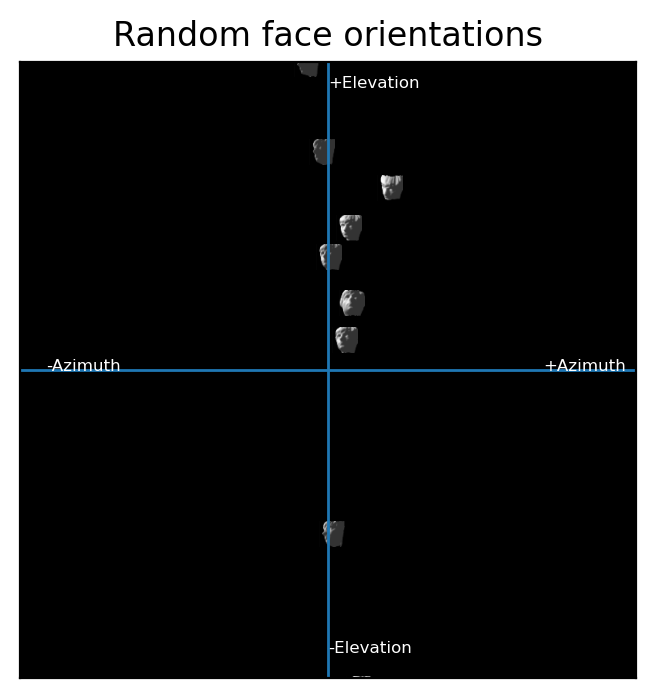

In [40]:
## create some test initial conditions
# you may have to run a few times to get images in the image!

random_theta, unflatten = initial_conditions( [[1024,32], [32, 16],  [16, 8], [8,2]], 0.2)
# predict the outputs (will be random junk)
predicted_outputs = [predict(face_inputs[i], random_theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))
plt.gca().set_title("Random face orientations")

**Task B.5** Write a function `total_face_loss` that computes the sum of the objective function value for *every* matched input and output pair from `face_inputs` and `expected_face_orientations`. 

In [41]:
# compute the sum of losses
# for every pair of xs and ys
def total_face_loss(theta, unflatten):
    total_loss = 0
    for i in range(len(face_inputs)): #698 TODO
        x = face_inputs[i]
        y = expected_face_orientations[i]
        loss = face_loss(theta, unflatten, x,y)
        total_loss += loss
    return total_loss  #837.231366447117

    # YOUR CODE HERE
    # raise NotImplementedError()
    

In [42]:
np.random.seed(2018)
# create some test initial conditions
random_theta, random_unflatten = flatten([np.random.normal(0,1,(1024,4)), np.random.normal(0,1,(4,2))])
with tick.marks(2):
    assert(np.allclose(total_face_loss(random_theta, random_unflatten), 1552.8832, atol=1e-1))

## Gradient descent learning

We could in principle use random search or hillclimbing but it will not give a very good results (trust me) and we jump directly to what we know is a beter method, namely gradient descent.

In this task, you will have to define a function `sgd_learn`. This will perform a simple form of (stochastic) gradient descent.

**Task B.6** Using automatic differentiation provided by `autograd`, compute the derivative of this loss function, and call it `grad_face_loss`. Hint: this is trivial.

In [43]:
grad_face_loss = grad(face_loss)
# raise NotImplementedError()

In [44]:
flat, unflatten = flatten(np.array([1,2,3]))
test_network = [np.array([[1,0.5,-0.5], [0.0, 2.0, -1.0]]).T, 
                np.array([[2.0, 1.0], [1.0, -1.0]]).T]
test_theta, test_unflatten = flatten(test_network)

with tick.marks(4):
    assert(abs(np.sum(grad_face_loss(test_theta, test_unflatten, np.array([1,2,3]), np.array([-1, 1])))-4.479)<0.2)

**Task B.7** 

Now we must define a function to perform stocahstic gradient descent.

`sgd_learn` should:

* take a list of matrix `shapes`, a `sigma` to specify the random initialisation of those matrices, a `step` size and a number of `iterations`
* generate an initial `theta` from that set of shapes, using the `initial_condition()` function you defined above.
* for each of the given number of iterations
    * randomly select *ONE* input vector (from `inputs`) and matching output vector (from `outputs`).
    * compute the gradient of the objective function for that image/output pair
    * make a step, adjusting `theta` in the direction of this gradient, scaled by the step size
    * print the iteration count every 500 iterations (i.e. for each 500 random data points) so you can see that the function is running correctly
    * evaluate the objective function at each iteration, and print out the sum of the objective function value over the last 500 iterations in your print statement; append this value to an array called `hist_loss_500`
    
* return the flattened vector, the corresponding unflatten function and the loss in each iteration 

The function definition should look like:

        def sgd_learn(shapes, inputs, outputs, sigma, step, iters):
            ...        
            return theta, unflatten, hist_loss_500

Note: You don't need to implement *any* sophistications like momentum or random restart. You don't need to collect the data into minibatches. The algorithm you implement should be very simple. 


In [45]:
def sgd_learn(shapes, inputs, outputs, sigma=0.1, step=0.1, iters=10000):    
    theta, unflatten = initial_conditions(shapes, sigma)  #这是随机生成的矩阵
    hist_loss_500 = [] #500次迭代的损失
    for iteration in range(iters):
        idx = np.random.randint(len(inputs))  
        x = inputs[idx]  #从输入，输出数据随机选一个节点
        y = outputs[idx]
        grad = grad_face_loss(theta, unflatten, x, y) #确定他的梯度，这表明需要在这个方向增加权重
        theta -= step * grad  #反方向step的步数
        if iteration % 500 == 0: #每当迭代次数达到500次
            loss_500 = 0
            for i in range(500):
                idx = np.random.randint(len(inputs))
                x = inputs[idx]
                y = outputs[idx]
                loss_500 += face_loss(theta, unflatten, x, y) #计算500次的损失值
            hist_loss_500.append(loss_500)
        if iteration % 500 == 0:
            print(f"Iteration {iteration}: loss_500 = {loss_500}") #打印，然后打到list里
    # raise NotImplementedError()
    return theta, unflatten, hist_loss_500

In [46]:
# verify that the shapes come out right
with tick.marks(4):
    test_theta, test_unflatten, hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.1, 0.1, 1)
    unflattened = test_unflatten(test_theta)
    assert(len(unflattened)==1)
    assert((unflattened[0].shape)==(1024,2))


Iteration 0: loss_500 = 8799.049525846416


In [47]:
## verify that some learning happens
with tick.marks(8):
    test_theta, test_unflatten, test_hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.01, 0.001, 0)
    before_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]
    test_theta, test_unflatten, test_hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.02, 0.001, 200)
    after_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]
    print("Mean loss before optimising %.2f; after optimising %.2f" % (np.mean(before_losses),  np.mean(after_losses)))
    assert(np.mean(after_losses)-np.mean(before_losses)<-0.01)
    print("Something was learned!")        

Iteration 0: loss_500 = 130.30498146194859
Mean loss before optimising 0.27; after optimising 0.12
Something was learned!


**Task B.8**

Use this function to learn an approximate mapping from face images to 2D vectors. You will have to choose:
* a **step size** (values in the range 0.1 to 0.0001 are reasonable)
* the **sigma** for the initial conditions (values in the range 0.5 to 0.005 are reasonable).

These are **hyperparameters** of the optimisation process. 

* You should use *no more* than 20000 iterations in the learning process. 

**Warning: if your call to `sgd_learn` takes more than ten minutes to run, the autograder will not accept your result!** *(For reference, 12K iterations run in under one minute on my laptop, so if you're over 5 minutes there is probably something wrong in your code!)*

Use `[[1024,32], [32, 16],  [16, 8], [8,2]]` as the list of shapes, *or* choose your own set of matrix shapes (just don't make them so large the optimisation takes forever).


In [48]:
## Run sgd_learn(...) in this cell
## produce the output theta, unflatten
## theta, unflatten = learn(...
## LEAVE THE SEED HERE TO FORCE CONSISTENT RESULTS!
np.random.seed(2023) # DO NOT MODIFY 
#############################################
step_size = 0.01
initial_sigma = 0.1
iterations = 10000
matrix_shapes = [[1024, 32], [32, 16], [16, 8], [8, 2]]

theta, unflatten, hist_loss_500 = sgd_learn(matrix_shapes, face_inputs, expected_face_orientations, initial_sigma, step_size, iterations)

final_loss = total_face_loss(theta, unflatten)
print(f"Final Loss: {final_loss}")
# YOUR CODE HERE
# raise NotImplementedError()

Iteration 0: loss_500 = 107.05324158263815


Iteration 500: loss_500 = 37.66910232162581
Iteration 1000: loss_500 = 26.512270043639916
Iteration 1500: loss_500 = 33.59245057453808
Iteration 2000: loss_500 = 20.2720144290377
Iteration 2500: loss_500 = 17.93347381175449
Iteration 3000: loss_500 = 17.782799676721808
Iteration 3500: loss_500 = 13.525935424713836
Iteration 4000: loss_500 = 20.077039451668817
Iteration 4500: loss_500 = 14.18824872572606
Iteration 5000: loss_500 = 16.688648621711394
Iteration 5500: loss_500 = 12.38370043019257
Iteration 6000: loss_500 = 11.232992171188952
Iteration 6500: loss_500 = 11.031928726522278
Iteration 7000: loss_500 = 10.068565876672716
Iteration 7500: loss_500 = 10.324611963087394
Iteration 8000: loss_500 = 9.210643298941376
Iteration 8500: loss_500 = 13.298816678967913
Iteration 9000: loss_500 = 11.210597787640344
Iteration 9500: loss_500 = 8.943621464398015
Final Loss: 16.735231532079432


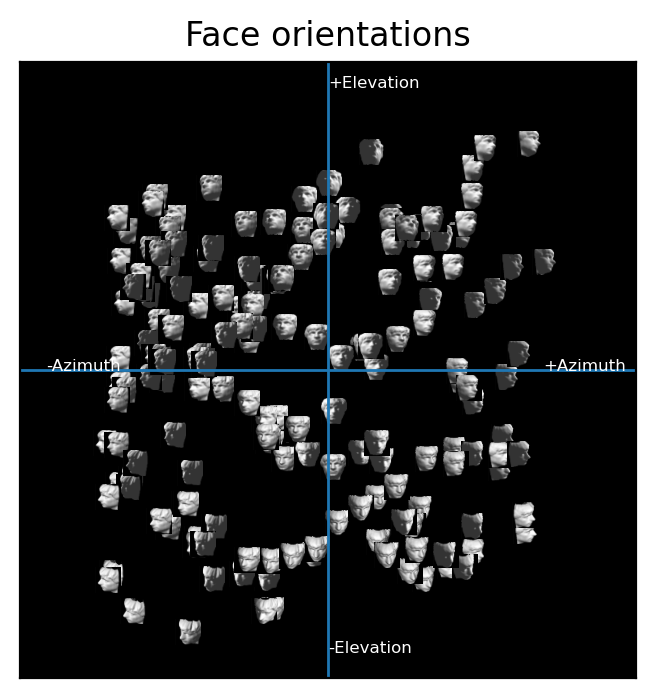

In [49]:
# if your code worked, then it should be able to predict
# what the orientation of the face is, from the image of the face
# this should be very close to the faces image plotted above
predicted_outputs = [predict(face_inputs[i], theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))

**Task B.9 Optional visualisation [ungraded, no marks]**

We encourage you to produce a figure showing the convergence of your algorithm (`fig_b9`). It should of course follow best pratice for visualisation (see resources on Moodle if your are in doubt about this). You can use the previously implemented `hist_loss_500` array for this. Provide an description and analysis of the convergence behaviour based on the averaged loss function in `hist_loss_500` (max 200 words). 
 
***The task is ungraded but we recommend you discuss the solution with your lab group and lab assistant.***
 

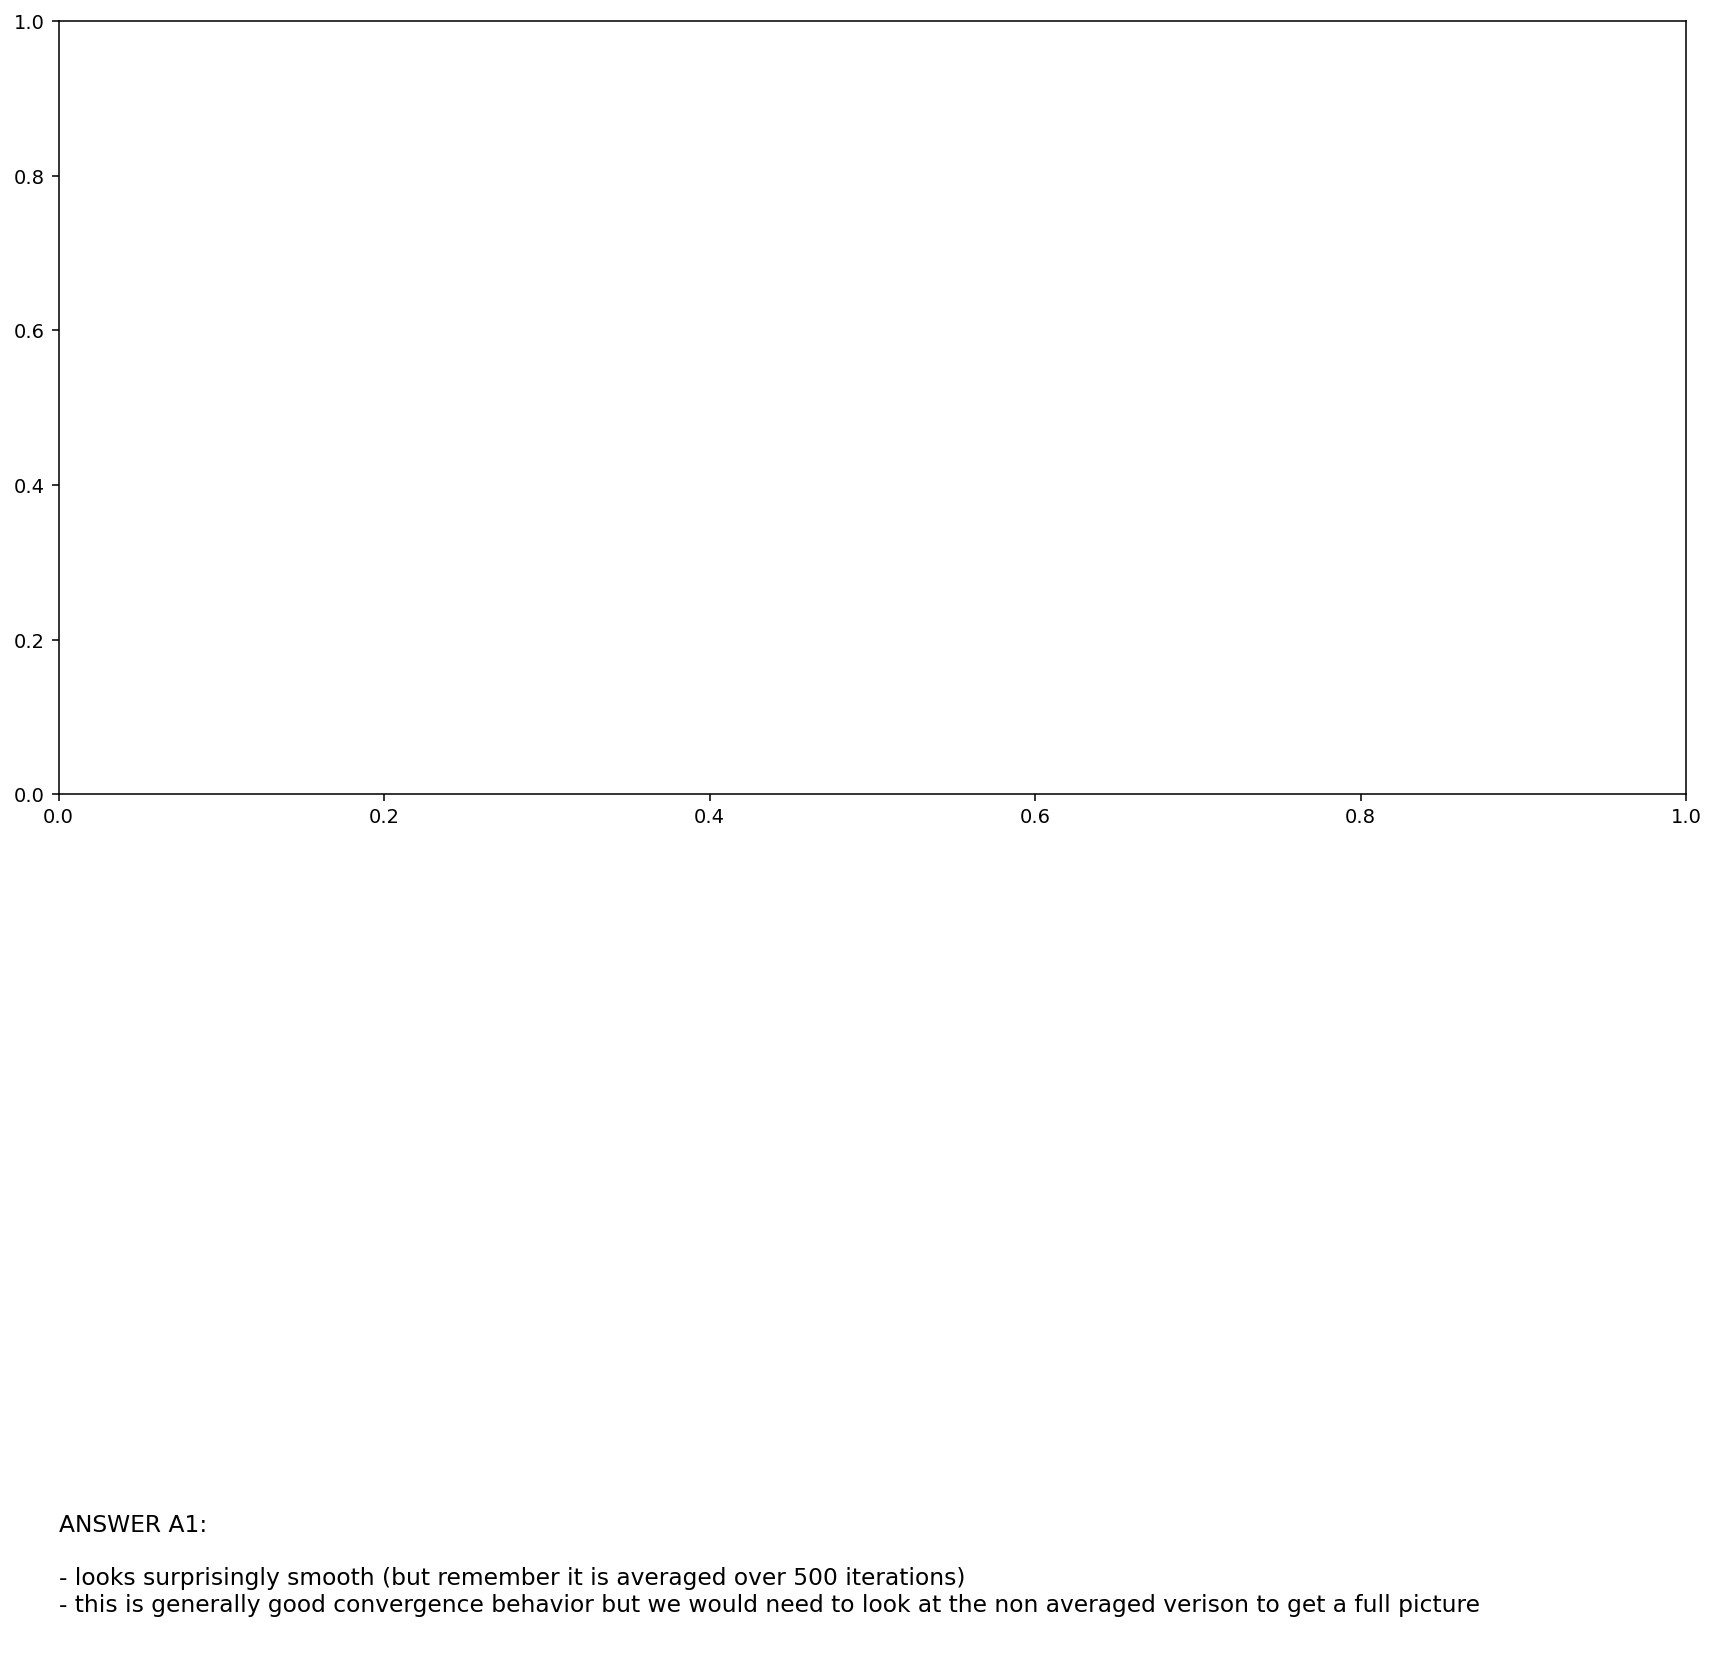

In [50]:
# Create the figure (do not chnage the fig handle name)
fig_b9 = plt.figure(figsize=(15,15))
ax_explanation = fig_b9.add_subplot(4,1,(3,4))
ax = fig_b9.add_subplot(4,1,(1,2))
#########################################

B9_EXPLANATION = """
- This graph illustrates the convergence behavior of the SGD algorithm. The x-axis represents the number of iterations, while the y-axis represents the average loss value (averaged over every 500 iterations).
- It is evident from the graph that the loss value gradually decreases as the number of iterations increases, showing promising convergence behavior. In the initial iterations, the loss decreases rapidly, followed by a slower descent rate in the later stages.
- The smooth curve indicates that the SGD algorithm fluctuates around local minima, eventually finding better parameter estimates. This behavior is generally desirable because SGD not only helps in reducing the loss but also aids in escaping local minima.
- The trend of the loss curve demonstrates the effectiveness of SGD on this problem, eventually discovering a set of parameters that minimizes the loss, thus learning a well-fitted mapping function.
"""

# YOUR CODE HERE
# raise NotImplementedError()
B9_EXPLANATION = """
- looks surprisingly smooth (but remember it is averaged over 500 iterations)
- this is generally good convergence behavior but we would need to look at the non averaged verison to get a full picture
"""

###################################################
### This adds your text (do not change this!)
ax_explanation.axis('off')
try:
    ax_explanation.text(0,0,("ANSWER A1:\n%s" % B9_EXPLANATION), fontsize=12)
except:
    ax_explanation.text(0,0,"ERROR A1_EXPLANATION NOT PROVIDED") 
    raise NotImplemented() # this is to give you an option to define A3_EXPLANATION above! 
###################################################

**Task B.10** 

In this part, we will automatically evaluate the performance of your model - you do not necessarily need to do anything to your code! Marks are awarded based on the quality of your model's performance and executed as hidden tests without immediate feedback.

To evaluate the quality of your predictions we will use the following metric called the root mean squared error:

$$rmse = \sqrt {\frac{1}{N\cdot D}\sum\limits_{n,d}^{} {\left( {{\vec{y}_{n,d}} - \vec{\hat y}_{n,d}} \right)^2} }$$ where $\vec{y}$ is a vector with the true image orientation values (*elevation* and *azimuth*) for image $n$. $\vec{\hat y}=f(\vec{x}_n;\theta)$ is a vector with the predicted values for image $n$. $d$ is used to index the *elevation* and *azimuth* values. $N$ is the number of images and $D$ is the number of image orientation values (i.e. two).

Your marks for this question will be awarded according to the following rule:
> rmse < 0.50: +9 marks
>
> rmse < 0.25: +8 marks
>
> rmse < 0.10: +7 marks
>
> rmse < 0.03: +4 marks ; note only four marks -- we don't want to to iterate this for ever!

So, you get more marks for answers that are better optimisers in the rmse sense.

*Note*: you will have to implement the $rmse$ function yourself if you want to know your your final score before submitting it (this is optional).

In [51]:
## Hidden rmse test [9 marks]

In [52]:
## Hidden rmse test [8 marks]

In [53]:
## Hidden rmse test [7 marks]

In [54]:
## Hidden rmse test [4 marks]

In [55]:
def rmse(y_true,y_pred):
    squared_errors = (y_true - y_pred) **2
    mean_squared_errors = np.mean(squared_errors)
    root_mean_squared_errors = np.sqrt(mean_squared_errors)
    return root_mean_squared_errors
y_true = expected_face_orientations
y_predict = predicted_outputs
a = rmse(y_true,y_predict)
print(a)

0.020028206454775294


# Summary 

If you've got this far, you've managed to build a system which can predict the orientation of the face from a picture of the face. All that was needed was some simple gradient descent, which optimised a function parameterised with a 20656 dimensional vector (the number of elements in `theta`).

This is not a perfect solution. It is not robust to noise, or to variations in the face position, scale or rotation. We have no idea if it generalises well to other images of the face than those we trained on. The mapping we used is extremely wasteful, and ignored the fact that pixels which are close together are probably related. All of these things would be fixed in a real deep learning approach, but the the principle remains the same. We create a parameterisable function, then optimise its parameters to align the approximation with some known training examples.

# Extra material
If you really want to understand what is going on in learning in deep networks, read [colah's blog](http://colah.github.io/posts/2015-08-Backprop/),  another [colah article](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/), and [Nielsen's free book](http://neuralnetworksanddeeplearning.com/), or [Deep learning from scratch](http://www.deepideas.net/deep-learning-from-scratch-i-computational-graphs/). You don't need to know **any** of this for this lab though!

# Submission on Moodle


We will generate the **one** pdf file you'll need to submit along with the notebook:

*Note*: you do not need to worry about the formatting etc (that's predetermined); just make sure all your explanations are readable in the pdf and your'll be fine!


In [56]:
## Report generation - YOU MUST YOU RUN THIS CELL !
#
#
# Ignore warnings regarding fonts
#

from matplotlib.backends.backend_pdf import PdfPages

# File 1: declaration of originality with system info
try:
    f = open('uofg_declaration_of_originality.txt','r')
    uofg_declaration_of_originality = f.read()
except: 
    uofg_declaration_of_originality = "uofg_declaration_of_originality not present in cwd"

try:
    student_id.lower()
except: 
    student_id="NORESPONSE"
try:
    student_typewritten_signature.lower()
except: 
    student_typewritten_signature="NORESPONSE"

fn = ("idss_lab2_optimisation_%s_declaration.pdf" % (student_id.lower()))
fig_dec = plt.figure(figsize=(10, 12)) 
fig_dec.text(0.1,0.1,("%s\n\n Student Id %s\n\n Typewritten signature: %s\n\n UUID System: %s" % (uofg_declaration_of_originality,student_id, student_typewritten_signature, uuid_system)))
   
    
# Combined: 
fn = ("idss_lab2_optimisation_%s_combined_v20232024a.pdf" % (student_id))
pp = PdfPages(fn)
pp.savefig(fig_a1b)
pp.savefig(fig_b9)
pp.savefig(fig_dec)
pp.close()

with tick.marks(0):  # have you generated the combined file...? you don't actually get any credit for this just confirmation that the file has been generated
    assert(os.path.exists(fn))


<Figure size 1400x1680 with 0 Axes>

**You must (for full or partial marks) submit via Moodle:**

- this notebook (completed) after "Restart and rerun all":
    - `idss_lab2_optimisation_v2023024a.ipynb`
    
- the combined pdf (autognerated) containing the originality statement, optional figures and signature
     - `idss_lab2_optimisation_[YOUR STUDENT ID]_combined_v20232024a.pdf`    

# Appendix: Marking Summary (and other metadata)
#### - make sure the notebook runs without errors (remove/resolve the `raise NotImplementedError()`) and "Restart and Rerun All" cells to get a correct indication of your marks.

In [57]:
print("Marks total : ","100")
print("Marks visible (with immediate feedback): ","60")
print("Marks hidden (without immediate feedback): ","40")
print("\nThe fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:")
tick.summarise_marks() # 
print("- the autograded (and visible) marks account for at least 50% of the total lab assesment.")

Marks total :  100
Marks visible (with immediate feedback):  60
Marks hidden (without immediate feedback):  40

The fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:


- the autograded (and visible) marks account for at least 50% of the total lab assesment.
